<a href="https://colab.research.google.com/github/GianluigiTod/Progetto-E-commerce/blob/main/Progetto_Quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install scikit-learn
!pip install pandas
!pip install qiskit
!pip install pylatexenc

In [15]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=123
)

print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Normalizzazione del data set

In [16]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)
features[:10]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

Definiamo il circuito per l'encoding dei dati

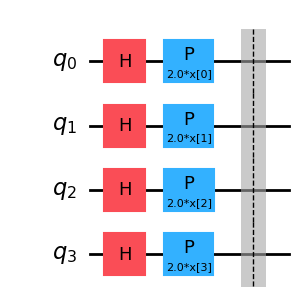

In [17]:
from qiskit.circuit.library import ZFeatureMap

num_features = features.shape[1]

feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

Adesso creo l'Ansatz con TwoLocal

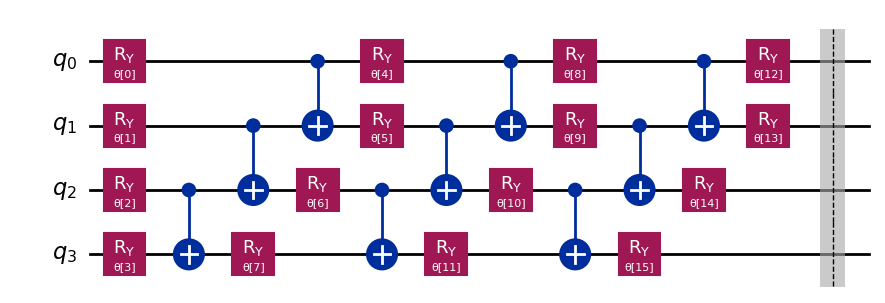

In [18]:
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2

ansatz=TwoLocal(num_features, 'ry', 'cx', 'reverse_linear', reps=3)
ansatz.barrier()
ansatz.decompose().draw(output="mpl", fold=20)

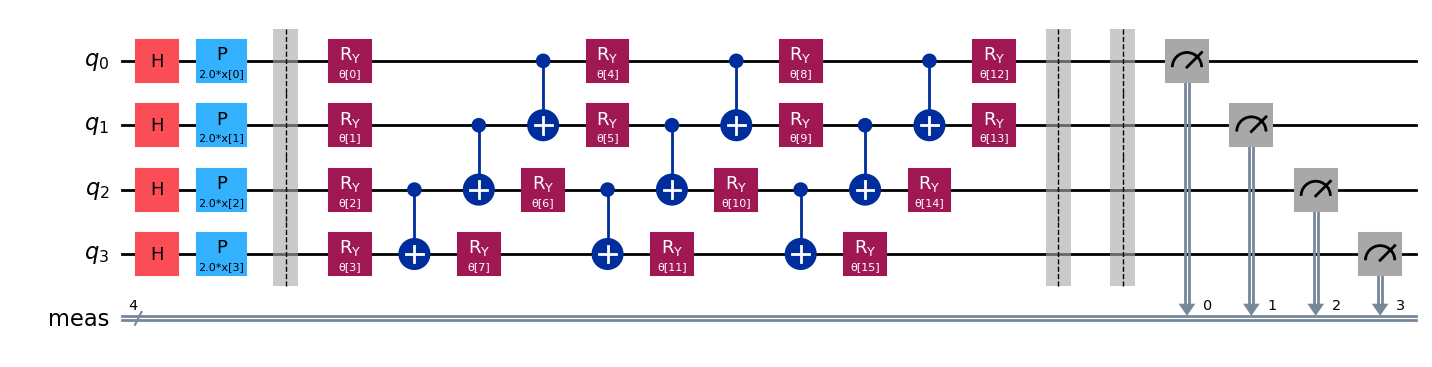

In [19]:
final_circuit=feature_map.compose(ansatz)
final_circuit.measure_all()
final_circuit.decompose().draw(output="mpl", fold=20)

Ora definiamo la funzione di costo

In [31]:
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler
from sklearn.linear_model import LogisticRegression
'''
def circuit_instance(tuple, variational):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return final_circuit.assign_parameters(parameters)

def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 3



def label_probability(results):
    shots = sum(results.values())
     #probabilities = {0: 0, 1: 0}
    probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities


def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost=log_loss(y_true=labels,y_pred=[[p[0],p[1],p[2]] for p in classifications])
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(train_features, train_labels, variational)
'''

def circuit_instance(tuple, variational):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return final_circuit.assign_parameters(parameters)

def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 3



def label_probability(results):
    shots = sum(results.values())
     #probabilities = {0: 0, 1: 0}
    probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

# 1. Funzione per ottenere le caratteristiche dai dati (output del circuito quantistico)
def get_quantum_features(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()

    features = []
    for result in results:
        probabilities = label_probability(result.data.meas.get_counts())  # Estrai le probabilità
        features.append([probabilities[0], probabilities[1], probabilities[2]])  # Adatta a 3 classi
    return np.array(features)

# 2. Funzione per l'ottimizzazione (cost function)
def cost_function(data, labels, variational):
    features = get_quantum_features(data, variational)  # Estrai le caratteristiche dal circuito
    cost = log_loss(y_true=labels, y_pred=features)  # Calcola la log loss
    print(cost)
    return cost

# 3. Funzione obiettivo per l'ottimizzazione
def objective_function(variational):
    return cost_function(train_features, train_labels, variational)

# 4. Applicare un classificatore classico (Logistic Regression)
def train_classifier(data, labels, variational):
    features = get_quantum_features(data, variational)  # Estrai le caratteristiche dai dati
    classifier = LogisticRegression()  # O qualsiasi altro classificatore
    classifier.fit(features, labels)  # Addestra il classificatore
    return classifier

In [32]:
import numpy as np
from scipy.optimize import minimize


initial_point = np.zeros((ansatz.num_parameters))
res = minimize(objective_function, initial_point, method="COBYLA", options={"maxiter":5000, "fatol":1e-6})

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:744: OptimizeWarning: Unknown solver options: fatol
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


1.0971199122782442
1.1799230539703358
1.1191027943623304
1.0469716470903556
1.1446130459833903
1.084127130025524
1.1431276171072602
1.0646265406113131
1.1493110742443002
1.0534535648425742
1.1233142515680101
1.0446501187498614
1.0310603501188513
1.0039914725742833
1.0600239120789638
1.2515663044434027
0.9844418444694445
0.9876957044329068
0.9556993628273236
0.8714888286555666
0.8824947436600165
0.9171017590717667
1.0666675235259802
0.924129837854369
0.847843836726543
0.869770140115608
0.7860600535452359
0.74477128555728
0.7871710830141407
0.7707330726314062
0.850994456508889
0.7943305994505199
0.8721298357940225
0.7827684228417261
0.9528166182445257
0.8438945114759019
0.7466445630974261
0.7872247274729989
0.7372149991540126
0.7503683699994831
0.7471353562038255
0.7111546916270112
0.716787049428011
0.7276952782298337
0.7219670694351662
0.7102165719031907
0.7110942488202269
0.6893573610046756
0.6761276704275538
0.6910196565238188
0.6983527481511848
0.6818792516808585
0.6802596774239138
0

KeyboardInterrupt: 

Valutazione della classificazione

In [28]:
from sklearn.metrics import accuracy_score
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy=accuracy_score(labels, predictions)
    return accuracy, predictions

accuracy_train, train_predictions = test_classifier(train_features, train_labels, res.x)
accuracy_test, test_predictions = test_classifier(test_features, test_labels, res.x)

print(f"Accuratezza Training: {accuracy_train:.4f}")
print(f"Accuratezza Test: {accuracy_test:.4f}")


[{0: 0.080078125, 1: 0.2138671875, 2: 0.7060546875}, {0: 0.0205078125, 1: 0.3720703125, 2: 0.607421875}, {0: 0.9091796875, 1: 0.0478515625, 2: 0.04296875}, {0: 0.7333984375, 1: 0.208984375, 2: 0.0576171875}, {0: 0.1455078125, 1: 0.5830078125, 2: 0.271484375}, {0: 0.0234375, 1: 0.4794921875, 2: 0.4970703125}, {0: 0.04296875, 1: 0.3291015625, 2: 0.6279296875}, {0: 0.5576171875, 1: 0.2587890625, 2: 0.18359375}, {0: 0.51171875, 1: 0.2626953125, 2: 0.2255859375}, {0: 0.181640625, 1: 0.5224609375, 2: 0.2958984375}, {0: 0.0283203125, 1: 0.4501953125, 2: 0.521484375}, {0: 0.75, 1: 0.171875, 2: 0.078125}, {0: 0.29296875, 1: 0.30078125, 2: 0.40625}, {0: 0.31640625, 1: 0.3837890625, 2: 0.2998046875}, {0: 0.1640625, 1: 0.2548828125, 2: 0.5810546875}, {0: 0.3125, 1: 0.2763671875, 2: 0.4111328125}, {0: 0.3623046875, 1: 0.3740234375, 2: 0.263671875}, {0: 0.142578125, 1: 0.4951171875, 2: 0.3623046875}, {0: 0.642578125, 1: 0.291015625, 2: 0.06640625}, {0: 0.7978515625, 1: 0.1416015625, 2: 0.060546875},